**Тема:** Метод главных компонент (PCA) + kNN для распознавания рукописных цифр MNIST

**Краткое содержание:** загрузка данных, реализация `my_PCA`, `my_kNN`, анализ собственных значений, визуализация, подбор числа компонент и числа соседей, выводы.


In [2]:
# Ядро: импорты и настройки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mnist import load_mnist 


In [3]:
# Загружаем данные (train, validation, test) — train и validation вместе имеют метки и изображения
train, validation, test = load_mnist()  # возвращает кортежи (images, labels)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
train_images, train_labels = train
val_images, val_labels = validation
test_images, test_labels = test

# Объединяем train+validation как обучающую выборку, тест оставим как тест
X_train = np.concatenate([train_images, val_images], axis=0)  # shape (60000, 28, 28, 1) обычно
y_train = np.concatenate([train_labels, val_labels], axis=0)

In [5]:
# Уберём последнюю размерность depth=1 и превратим в векторы
def images_to_vectors(imgs):
    imgs = imgs.reshape(imgs.shape[0], -1).astype(np.float64)  # (N, 784)
    return imgs

X_train = images_to_vectors(X_train)  # (N_train, 784)
X_test = images_to_vectors(test_images)  # (N_test, 784)
y_test = test_labels

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape, "y_test.shape:", y_test.shape)

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
y_train.shape: (60000,) y_test.shape: (10000,)


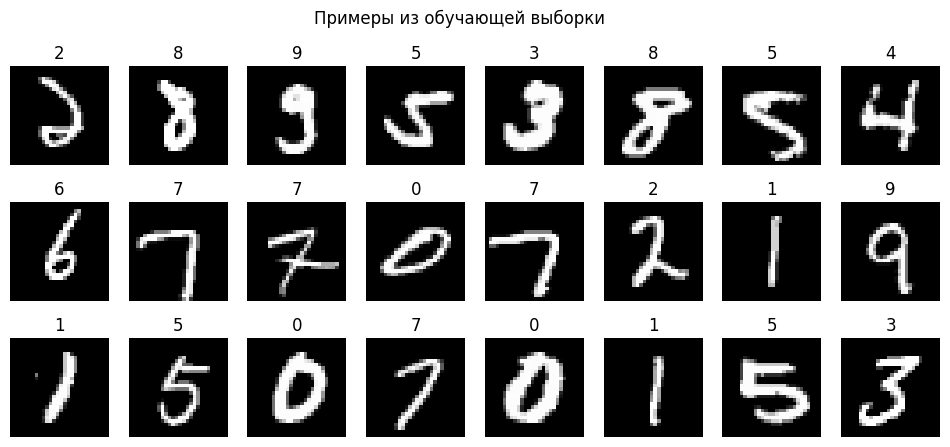

In [6]:
# Визуализация нескольких примеров
fig, axes = plt.subplots(3, 8, figsize=(12,5))
indices = np.random.choice(np.arange(X_train.shape[0]), size=24, replace=False)
for ax, idx in zip(axes.ravel(), indices):
    ax.imshow(X_train[idx].reshape(28,28), cmap='gray')
    ax.set_title(int(y_train[idx]))
    ax.axis('off')
plt.suptitle("Примеры из обучающей выборки")
plt.show()

In [17]:
class my_PCA:
    def __init__(self, n_components=None):
        """
        n_components: None (все) или число компонент (int)
        """
        self.n_components = n_components
        self.components_ = None  # собственные векторы (строки: компоненты)
        self.explained_variance_ = None  # собственные значения (дисперсии)
        self.mean_ = None

    def fit(self, X):
        """
        X: array (n_samples, n_features)
        """
        X = np.asarray(X, dtype=np.float64)
        n_samples, n_features = X.shape
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_
        # SVD: Xc = U * S * Vt
        # Вычисление ковариационных собственных значений: S^2 / (n_samples-1)
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        # Vt.shape = (min(n_samples, n_features), n_features)
        # объясненная дисперсия (собственные значения ковариационной матрицы)
        explained_variance = (S ** 2) / (n_samples - 1)
        # Упорядочены по убыванию S => explained_variance убывает
        # Сохранить нужное количество компонент
        if self.n_components is None:
            k = Vt.shape[0]
        else:
            k = int(self.n_components)
            k = min(k, Vt.shape[0])
        self.components_ = Vt[:k, :]  # каждая строка — главная компонента (вектор признаков)
        self.explained_variance_ = explained_variance[:k]
        return self

    def transform(self, X):
        """
        Проекция X на первые n_components компонент: Y = (X - mean) @ components_.T
        Возвращает (n_samples, n_components)
        """
        X = np.asarray(X, dtype=np.float64)
        Xc = X - self.mean_
        return np.dot(Xc, self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


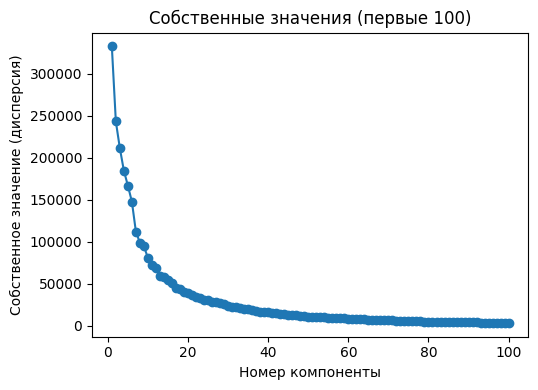

In [18]:
# Для скорости можно взять небольшую подвыборку, но для точности рекомендуется использовать всю обучающую выборку
pca_full = my_PCA(n_components=100)  # больше, чем достаточно
pca_full.fit(X_train)
eigs = pca_full.explained_variance_
# График собственных значений
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(eigs)+1), eigs, marker='o')
plt.title("Собственные значения (первые {})".format(len(eigs)))
plt.xlabel("Номер компоненты")
plt.ylabel("Собственное значение (дисперсия)")
plt.tight_layout()
plt.show()

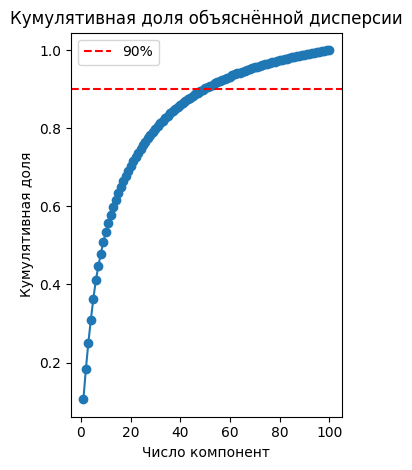

In [19]:
# Кумулятивная доля
cum = np.cumsum(eigs) / np.sum(eigs)
plt.subplot(1,2,2)
plt.plot(np.arange(1, len(eigs)+1), cum, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90%')
plt.title("Кумулятивная доля объяснённой дисперсии")
plt.xlabel("Число компонент")
plt.ylabel("Кумулятивная доля")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Доля дисперсии первых 15 компонент:
if len(eigs) >= 15:
    frac15 = np.sum(eigs[:15]) / np.sum(eigs)
    print("Доля дисперсии, покрываемая первыми 15 компонентами: {:.4f}".format(frac15))
else:
    print("Мало компонент, всего", len(eigs))


Доля дисперсии, покрываемая первыми 15 компонентами: 0.6334


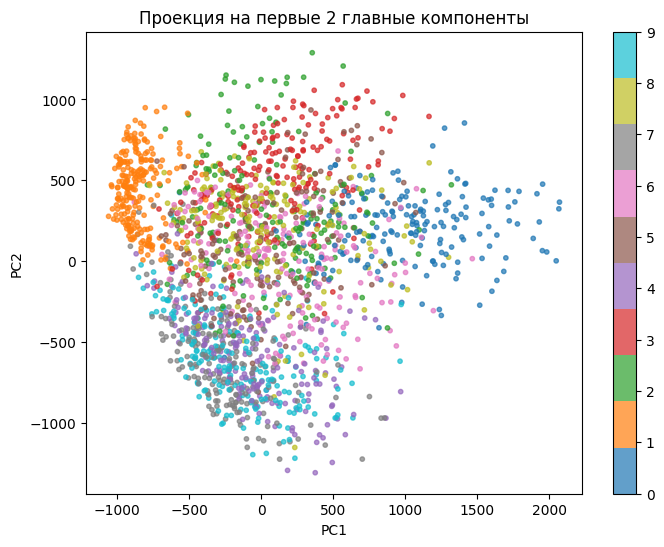

In [21]:
# Проекция на 2 главные компоненты
pca2 = my_PCA(n_components=2)
X_train_2 = pca2.fit_transform(X_train)

# Визуализация (выбор подвыборки для читаемости)
np.random.seed(0)
sel = np.random.choice(np.arange(X_train_2.shape[0]), size=2000, replace=False)
Xvis = X_train_2[sel]
yvis = y_train[sel]

plt.figure(figsize=(8,6))
scatter = plt.scatter(Xvis[:,0], Xvis[:,1], c=yvis, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Проекция на первые 2 главные компоненты")
plt.colorbar()
plt.show()


In [22]:
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = int(n_neighbors)
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=np.float64)
        self.y_train = np.asarray(y)
        return self

    def _pairwise_distances(self, A, B):
        # Вычисление евклидовых расстояний между каждыми строками A и B 
        # dist^2 = sum(A^2, axis=1)[:,None] + sum(B^2)[None,:] - 2 A B^T
        A2 = np.sum(A**2, axis=1)[:, None]
        B2 = np.sum(B**2, axis=1)[None, :]
        AB = A.dot(B.T)
        d2 = A2 + B2 - 2*AB
        d2 = np.maximum(d2, 0.0)
        return np.sqrt(d2)

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        D = self._pairwise_distances(X, self.X_train)
        # для каждой строки берём индексы k ближайших
        idx = np.argpartition(D, self.n_neighbors-1, axis=1)[:, :self.n_neighbors]
        # теперь выбираем наиболее частый класс среди соседей
        y_pred = []
        for i in range(X.shape[0]):
            neigh_labels = self.y_train[idx[i]]
            # выборка: самый частый класс; при равенстве — минимальный класс
            vals, counts = np.unique(neigh_labels, return_counts=True)
            winner = vals[np.argmax(counts)]
            y_pred.append(winner)
        return np.array(y_pred)


In [23]:
# Разделить данные на train/test — обрезать данные для ускорения
X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Выборка
n_train_demo = 5000
n_test_demo = 2000
idx_train = np.random.choice(np.arange(X_train_small.shape[0]), size=n_train_demo, replace=False)
idx_test = np.random.choice(np.arange(X_test.shape[0]), size=n_test_demo, replace=False)

Xtr_demo = X_train_small[idx_train]
ytr_demo = y_train_small[idx_train]
Xte_demo = X_test[idx_test]
yte_demo = y_test[idx_test]

knn = my_kNN(n_neighbors=5)
knn.fit(Xtr_demo, ytr_demo)
y_pred = knn.predict(Xte_demo)
acc = accuracy_score(yte_demo, y_pred)
print("Точность my_kNN (demo): {:.4f}".format(acc))


Точность my_kNN (demo): 0.9385


In [24]:
# Составление подвыборок
# Обучающая и тестовая подвыборки
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

# Выставление размеров
max_train = 8000
max_test = 2000
if X_train_small.shape[0] > max_train:
    idx = np.random.choice(np.arange(X_train_small.shape[0]), size=max_train, replace=False)
    X_train_small = X_train_small[idx]; y_train_small = y_train_small[idx]
if X_test_small.shape[0] > max_test:
    idx = np.random.choice(np.arange(X_test_small.shape[0]), size=max_test, replace=False)
    X_test_small = X_test_small[idx]; y_test_small = y_test_small[idx]

print("Используем данные: train", X_train_small.shape, "test", X_test_small.shape)

Используем данные: train (8000, 784) test (2000, 784)


In [25]:
# Подбор параметров
max_components = 32  # можно 784, но это долго
components_list = list(range(1, max_components+1))
neighbors_list = list(range(1, 31))

results = np.zeros((len(components_list), len(neighbors_list)))

In [26]:
for i, n_comp in enumerate(components_list):
    # Подгоняем PCA на обучающей части
    pca = my_PCA(n_components=n_comp)
    Xtr_p = pca.fit_transform(X_train_small)
    Xte_p = pca.transform(X_test_small)
    for j, k in enumerate(neighbors_list):
        knn = my_kNN(n_neighbors=k)
        knn.fit(Xtr_p, y_train_small)
        ypred = knn.predict(Xte_p)
        acc = accuracy_score(y_test_small, ypred)
        results[i, j] = acc
    print(f"Готово для n_comp={n_comp} (макс точность на этой строке = {results[i].max():.4f})")

Готово для n_comp=1 (макс точность на этой строке = 0.2840)
Готово для n_comp=2 (макс точность на этой строке = 0.4580)
Готово для n_comp=3 (макс точность на этой строке = 0.5010)
Готово для n_comp=4 (макс точность на этой строке = 0.6405)
Готово для n_comp=5 (макс точность на этой строке = 0.7550)
Готово для n_comp=6 (макс точность на этой строке = 0.8345)
Готово для n_comp=7 (макс точность на этой строке = 0.8740)
Готово для n_comp=8 (макс точность на этой строке = 0.8910)
Готово для n_comp=9 (макс точность на этой строке = 0.9045)
Готово для n_comp=10 (макс точность на этой строке = 0.9205)
Готово для n_comp=11 (макс точность на этой строке = 0.9290)
Готово для n_comp=12 (макс точность на этой строке = 0.9390)
Готово для n_comp=13 (макс точность на этой строке = 0.9400)
Готово для n_comp=14 (макс точность на этой строке = 0.9435)
Готово для n_comp=15 (макс точность на этой строке = 0.9465)
Готово для n_comp=16 (макс точность на этой строке = 0.9480)
Готово для n_comp=17 (макс точнос

In [27]:
# Найдём наилучший результат
imax, jmax = np.unravel_index(np.argmax(results), results.shape)
best_ncomp = components_list[imax]
best_k = neighbors_list[jmax]
best_acc = results[imax, jmax]
print("Лучшие параметры: n_components =", best_ncomp, "n_neighbors =", best_k, "accuracy =", best_acc)

Лучшие параметры: n_components = 29 n_neighbors = 6 accuracy = 0.964


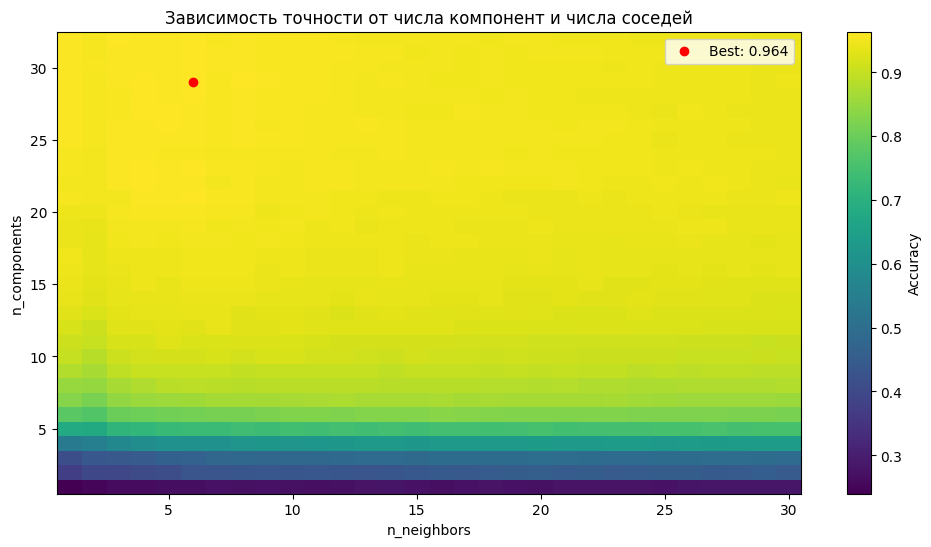

In [28]:
# Визуализация: heatmap точности
plt.figure(figsize=(12,6))
plt.imshow(results, aspect='auto', origin='lower', cmap='viridis',
           extent=[neighbors_list[0]-0.5, neighbors_list[-1]+0.5, components_list[0]-0.5, components_list[-1]+0.5])
plt.colorbar(label='Accuracy')
plt.xlabel("n_neighbors")
plt.ylabel("n_components")
plt.title("Зависимость точности от числа компонент и числа соседей")
plt.scatter([best_k], [best_ncomp], color='red', label=f'Best: {best_acc:.3f}')
plt.legend()
plt.show()

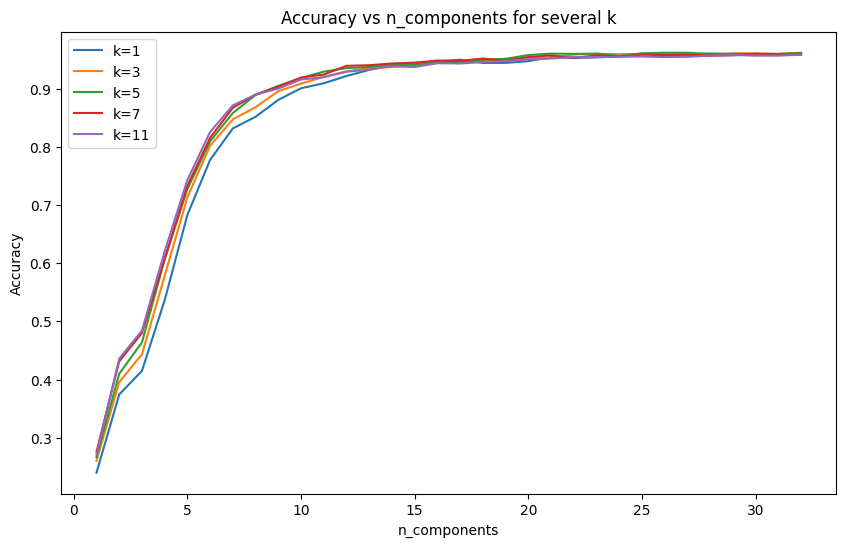

In [29]:
# Дополнительно: графики точности по числу компонент при фиксированных k (например k=1,3,5,7)
plt.figure(figsize=(10,6))
for k in [1,3,5,7,11]:
    plt.plot(components_list, results[:, neighbors_list.index(k)], label=f'k={k}')
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n_components for several k')
plt.legend()
plt.show()